# Deutsch-Jozsa algorithm

The goal of this notebook is to implement so called Deutsch-Jozsa algorithm, which is the first quantum algorithm showing an exponential speed-up over classical methods.

The algorithm is implementing a decision function finding the type of a hidden Boolean function given as an oracle. The Boolean function is promised to be either balanced, i.e., whose values are $0$ on half of its inputs, or constant, i.e., whose values are the same on all inputs.

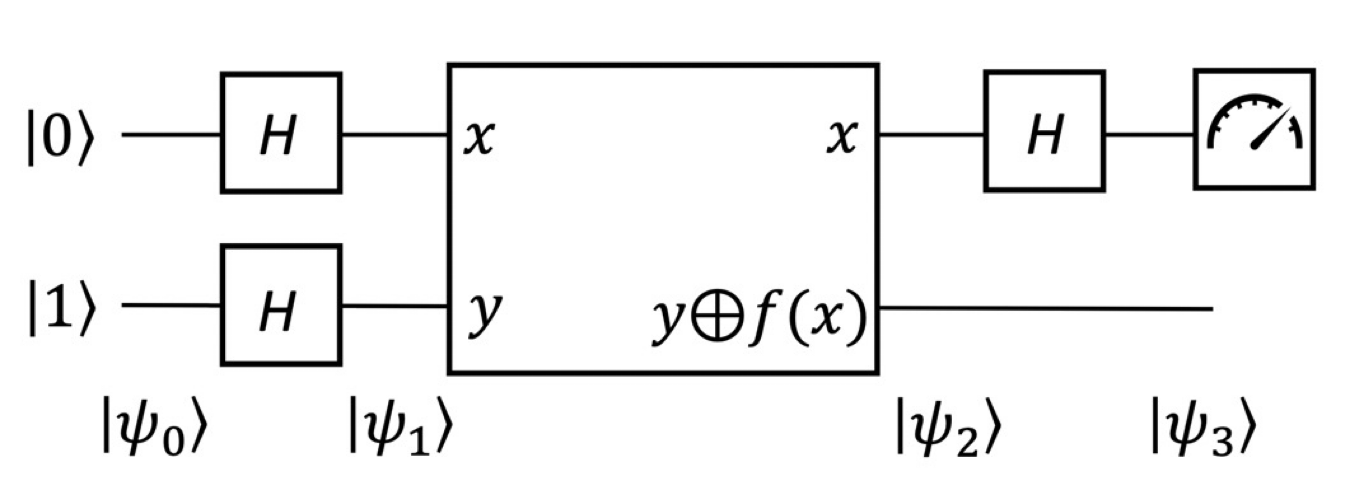

The algorithm in this notebook follows that in [Cleve et al. 1997](https://arxiv.org/pdf/quant-ph/9708016.pdf). We assume that the input to the oracle $f$ is a $n$-bit string. Namely, for each $x \in \{0,1\}^n$, the value of $f(x)$ is promised to be either constant, i.e., the same for all $x$, or balanced, i.e., exactly half of the $n$-bit string whose $f(x) = 0$.

# Case with n=1

In [ ]:
import qiskit as qs
from qiskit import QuantumCircuit, QuantumRegister,ClassicalRegister, execute
import qiskit.quantum_info as qi

Let us start with initializing $\psi_1$ as on the schema. We will define a circuit `init` representing this initialization.

In [ ]:
init = QuantumCircuit(2)

###ENTER CODE HERE
###END CODE

In [ ]:
init.draw()

=> circuit should look like this - note the barrier that will just be used to separate the different blocks
```
     ┌───┐      ░ 
q_0: ┤ H ├──────░─
     ├───┤┌───┐ ░ 
q_1: ┤ X ├┤ H ├─░─
     └───┘└───┘ ░ 
```

Let us now build the circuit `end` that will perform the measure, we need a classical bit for that

In [ ]:
###ENTER CODE HERE
###END CODE

In [ ]:
end.draw()

=> circuit should look like this
```
      ░ ┌───┐┌─┐
q_0: ─░─┤ H ├┤M├
      ░ └───┘└╥┘
q_1: ─░───────╫─
      ░       ║ 
c: 1/═════════╩═
```

Now let us build the 4 possible circuit corresponding to the 4 cases:
* $f(x)=0$ (_constant_)
* $f(x)=1$ (_constant_)
* $f(x)=x$ (_balanced_)
* $f(x)=\tilde x$ (_balanced_)

In [ ]:
# define unbalanced0, unbalanced1, balanced0, and balanced1 circuits following these definition
constant0 = QuantumCircuit(2)
###ENTER CODE HERE
###ENDCODE

constant1 = QuantumCircuit(2)
###ENTER CODE HERE
###ENDCODE

balanced0 = QuantumCircuit(2)
###ENTER CODE HERE
###ENDCODE

balanced1 = QuantumCircuit(2)
###ENTER CODE HERE
###ENDCODE

We can check the unitary corresponding to each as follow

In [ ]:
circuits = [('c', constant0), ('c', constant1), ('b', balanced0), ('b', balanced1)]

for type, oracle in circuits:
    if type == 'c':
        print("******** constant")
    else:
        print("******** balanced")
    print("- the full circuit:\n")
    print(init.compose(oracle).compose(end))
    print("- QASM representation\n", oracle.qasm())
    print("- the unitary:\n", qi.Operator(oracle).data)

In [ ]:
# Let us simulate the 4 circuit on a perfect and noisy simulator
from qiskit_ibm_provider import IBMProvider
from qiskit_aer import Aer, AerSimulator
provider = IBMProvider()

In [ ]:
local_aer_simulator = Aer.get_backend('aer_simulator')

In [ ]:
# pick one of the available backend (real_backend) and take a noisy simulator from it
###ENTER CODE HERE
###END CODE
local_noisy_simulator = AerSimulator.from_backend(real_backend)

In [ ]:
# Let us run the simulation of the perfect simulator

for type, oracle in circuits:
    circuit = init.compose(oracle).compose(end)
    transpiled = qs.transpile(circuit)
    counts = local_aer_simulator.run(transpiled, shots=100).result().get_counts()
    print(type, counts)

In [ ]:
# Do the same for the noisy simulator

###ENTER CODE HERE
###END CODE

# General Case

In [ ]:
# inspired from https://github.com/qiskit-community/qiskit-community-tutorials/blob/master/algorithms/deutsch_jozsa.ipynb

import numpy as np
n = 4

In [ ]:
# Choose a type of oracle at random. With probability half it is constant, 
# and with the same probability it is balanced
oracleType, oracleValue = np.random.randint(2), np.random.randint(2)

if oracleType == 0:
    print("The oracle returns a constant value ", oracleValue)
else:
    print("The oracle returns a balanced function")
    a = np.random.randint(1,2**n) # this is a hidden parameter for balanced oracle. 

# Creating registers
# n qubits for querying the oracle and one qubit for storing the answer
qr = QuantumRegister(n+1) #all qubits are initialized to zero
# for recording the measurement on the first register
cr = ClassicalRegister(n)

djCircuit = QuantumCircuit(qr, cr)

# Create the superposition of all input queries in the first register by applying the Hadamard gate to each qubit.
for i in range(n):
    djCircuit.h(qr[i])

# Flip the second register and apply the Hadamard gate.
djCircuit.x(qr[n])
djCircuit.h(qr[n])
    
# Apply barrier to mark the beginning of the oracle
djCircuit.barrier()

if oracleType == 0:#If the oracleType is "0", the oracle returns oracleValue for all input. 
    if oracleValue == 1:
        djCircuit.x(qr[n])
    else:
        djCircuit.id(qr[n])
else: # Otherwise, it returns the inner product of the input with a (non-zero bitstring) 
    for i in range(n):
        if (a & (1 << i)):
            djCircuit.cx(qr[i], qr[n])
        
# Apply barrier to mark the end of the oracle
djCircuit.barrier()

# Apply Hadamard gates after querying the oracle
for i in range(n):
    djCircuit.h(qr[i])
    
# Measurement
djCircuit.barrier()
for i in range(n):
    djCircuit.measure(qr[i], cr[i])

In [ ]:
djCircuit.draw(output='mpl', style="iqp", scale=0.5)

In [ ]:
shots = 1000

job_aer = execute(djCircuit, backend=local_aer_simulator, shots=shots)
results_aer = job_aer.result() 
answer_aer = results_aer.get_counts()

job_noisy = execute(djCircuit, backend=local_noisy_simulator, shots=shots)
results_noisy = job_noisy.result() 
answer_noisy = results_noisy.get_counts()

In [ ]:
from qiskit.tools.visualization import plot_histogram

In [ ]:
plot_histogram([answer_aer, answer_noisy], legend=["perfect", "noisy"])